## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
# using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
#=
import LossFunctions: HuberLoss, value
import Distributions: Chisq, ccdf
import StatsBase: mad, sample

function huberize(y::Vector{Float64})
    m = median(y)
    s = mad(y,normalize=true)
    z = (y.-m)./s
    l = value.(HuberLoss(1),z)
    x = sign.(z).* sqrt.(2*l)
    return m .+ s.*x
end
=#

## Load processed_data:

### By individuals:

In [5]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [6]:
BXD_pheno_ind_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_pheno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 32445 livear proteome.

In [7]:
println(size(BXD_pheno_ind_summary_df)) 
BXD_pheno_ind_summary_df[1:10, 1:10]

(248, 32448)


Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021
3,H2577,BXD9,9,12.415,10.487,17.89,17.488,17.594,16.731,16.208
4,H0365,BXD9,9,11.374,10.674,17.714,17.401,17.381,16.621,16.337
5,H1333,BXD13,13,11.687,11.524,17.362,17.367,17.071,16.465,15.97
6,H2259,BXD24,24,11.837,11.715,17.57,17.792,17.505,16.894,16.277
7,H1792,BXD24,24,11.563,11.434,17.789,17.847,17.416,17.042,16.292
8,H1791,BXD24,24,12.5,12.273,17.944,17.833,17.63,16.862,16.3
9,H1541,BXD24,24,11.815,11.564,17.794,17.759,17.456,16.878,16.377


In [8]:
BXD_geno_ind_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_geno_summary.csv", DataFrame);

By individuals, there are 248 individual samples for 7321 markers.

In [9]:
println(size(BXD_geno_ind_summary_df)) 
BXD_geno_ind_summary_df[1:10, 1:10]

(248, 7324)


Row,Sample,Strain,Strain_num,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H1009,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H0370,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H2577,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H0365,BXD9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,H1333,BXD13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,H2259,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,H1792,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,H1791,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,H1541,BXD24,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### By strains:

In [10]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [11]:
BXD_pheno_strains_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_pheno_strain_means_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 32445 liver proteome.

In [12]:
println(size(BXD_pheno_strains_summary_df)) 
BXD_pheno_strains_summary_df[1:10, 1:10]

(50, 32447)


Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98
3,BXD24,5,12.0778,11.7458,17.7926,17.8152,17.5168,16.9196,16.3012,16.4304
4,BXD27,3,11.717,11.149,17.336,17.3143,17.165,16.5283,15.9407,16.002
5,BXD29,11,11.735,11.3496,17.4583,17.3877,17.2431,16.4945,16.0869,16.1075
6,BXD32,8,11.6266,11.554,17.8254,17.7716,17.4639,16.9029,16.434,16.425
7,BXD34,13,11.7491,11.9135,17.6108,17.5974,17.2988,16.7761,16.3147,16.2926
8,BXD39,5,11.9158,11.719,17.395,17.385,17.157,16.5226,16.179,16.0594
9,BXD40,8,11.8651,11.6817,17.5986,17.6386,17.3861,16.6824,16.2855,16.2523


In [13]:
BXD_geno_strains_summary_df = CSV.read("../../../shareddata/BXDLongevity/data/GN886_geno_strains_summary.csv", DataFrame);

By strains, there are 50 BXD strains for 7321 markers.

In [14]:
println(size(BXD_geno_strains_summary_df)) 
BXD_geno_strains_summary_df[1:10, 1:10]

(50, 7322)


Row,Strain,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,BXD9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BXD13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BXD24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BXD27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BXD29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,BXD32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BXD34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BXD39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,BXD40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load functions:

In [15]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));

## Objectives

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

## Run BulkLMM.jl:

### Calculate kinship:

First, calculate the kinship matrix of relatedness among the strains (50-by-50):

In [16]:
geno_strains = Matrix{Float64}(BXD_geno_strains_summary_df[:, 2:end]);

In [17]:
kinship_strains = calcKinship(geno_strains);

Then, construct the kinship matrix of relatedness among the individuals based on which strain they are from:

In [34]:
function calcRepeats(x::Array{<:Any, 1})
    
    counting_dict = Dict{Any, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 3 methods)

In [19]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [35]:
BXD_geno_ind_summary_df.Strain_num = Vector{Int64}(BXD_geno_ind_summary_df.Strain_num);

In [36]:
BXD_geno_ind_summary_df.Strain_num

248-element Vector{Int64}:
   9
   9
   9
   9
  13
  24
  24
  24
  24
  24
  27
  27
  27
   ⋮
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102

In [47]:
s = "BXD" .* string.(collect(1:10))

10-element Vector{String}:
 "BXD1"
 "BXD2"
 "BXD3"
 "BXD4"
 "BXD5"
 "BXD6"
 "BXD7"
 "BXD8"
 "BXD9"
 "BXD10"

In [51]:
repeat(s[1:2], inner = 3)

6-element Vector{String}:
 "BXD1"
 "BXD1"
 "BXD1"
 "BXD2"
 "BXD2"
 "BXD2"

In [41]:
df1 = calcRepeats(BXD_geno_ind_summary_df.Strain_num)

Dict{Int64, Int64} with 50 entries:
  56 => 1
  55 => 1
  60 => 3
  32 => 8
  67 => 2
  45 => 5
  73 => 7
  64 => 3
  90 => 6
  13 => 1
  63 => 12
  86 => 4
  91 => 2
  62 => 5
  75 => 2
  43 => 4
  69 => 5
  68 => 2
  98 => 5
  39 => 5
  84 => 2
  77 => 6
  95 => 5
  66 => 5
  34 => 13
  ⋮  => ⋮

In [38]:
BXD_geno_ind_summary_df.Strain = BXD_geno_ind_summary_df.Strain |> Array{String}

248-element Vector{String}:
 "BXD9"
 "BXD9"
 "BXD9"
 "BXD9"
 "BXD13"
 "BXD24"
 "BXD24"
 "BXD24"
 "BXD24"
 "BXD24"
 "BXD27"
 "BXD27"
 "BXD27"
 ⋮
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"
 "BXD102"

In [39]:
typeof(BXD_geno_ind_summary_df.Strain)

Vector{String} (alias for Array{String, 1})

In [42]:
df_any = calcRepeats(BXD_geno_ind_summary_df.Strain)

Dict{Any, Int64} with 50 entries:
  "BXD53"  => 3
  "BXD32"  => 8
  "BXD70"  => 7
  "BXD79"  => 5
  "BXD48"  => 6
  "BXD60"  => 3
  "BXD13"  => 1
  "BXD69"  => 5
  "BXD90"  => 6
  "BXD49"  => 2
  "BXD51"  => 5
  "BXD84"  => 2
  "BXD101" => 5
  "BXD86"  => 4
  "BXD40"  => 8
  "BXD50"  => 3
  "BXD65"  => 13
  "BXD88"  => 1
  "BXD95"  => 5
  "BXD27"  => 3
  "BXD61"  => 8
  "BXD29"  => 11
  "BXD74"  => 1
  "BXD100" => 8
  "BXD91"  => 2
  ⋮        => ⋮

In [68]:
function createRanges(values::Array{Int64, 1})
    
    m = length(values); # number of strains
    
    list_ranges = Array{UnitRange{Int64}, 1}(undef, m)
    startpt = 1
    
    for i in 1:length(values)
        endpt = startpt+values[i]-1;
        list_ranges[i] = startpt:endpt
        startpt = endpt+1
    end
    
    return list_ranges
    
end

createRanges (generic function with 1 method)

In [69]:
typeof(1:3)

UnitRange{Int64}

In [70]:
example = [3, 2, 4];

In [78]:
test_ranges = createRanges(example)

3-element Vector{UnitRange{Int64}}:
 1:3
 4:5
 6:9

In [76]:
!(1 in 1:3)

false

In [88]:
function mapIds(id::Int64, ranges::Array{UnitRange{Int64}, 1})
    
    curr_group = 1;
    
    while !(id in ranges[curr_group])
        curr_group = curr_group+1;
    end
    
    return curr_group
    
end

mapIds (generic function with 1 method)

In [79]:
mapIdxs(7, test_ranges)

3

In [95]:
function mapValues(idx::Int64, idy::Int64, ranges::Array{UnitRange{Int64}, 1}, K::Array{Float64, 2})
    
    f_idx = mapIds(idx, ranges);
    f_idy = mapIds(idy, ranges);
    
    return K[f_idx, f_idy];
    
end

mapValues (generic function with 1 method)

In [97]:
function calcKinship2(kinship_strains::Array{Float64, 2}, 
                      strain_info_about_samples::Array{<:Any, 1})

    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    ranges = createRanges(reps_each_strain);
    
    n = sum(reps_each_strain); # total number of individual samples
    
    kinship_ind = ones(n, n);
    
    for i in 1:n
        for j in 1:n
            kinship_ind[i, j] = mapValues(i, j, ranges, kinship_strains);
        end
    end
    
    return kinship_ind;    

end

calcKinship2 (generic function with 1 method)

In [100]:
example_K = [1 0.5 0.6; 
             0.5 1 0.7;
             0.6 0.7 1]

3×3 Matrix{Float64}:
 1.0  0.5  0.6
 0.5  1.0  0.7
 0.6  0.7  1.0

In [102]:
example_strain_each_sample = [1, 1, 1, 2, 2, 3, 3, 3, 3];

In [104]:
@time example_test_K2 = calcKinship2(example_K, example_strain_each_sample)

  0.000012 seconds (13 allocations: 1.969 KiB)


9×9 Matrix{Float64}:
 1.0  1.0  1.0  0.5  0.5  0.6  0.6  0.6  0.6
 1.0  1.0  1.0  0.5  0.5  0.6  0.6  0.6  0.6
 1.0  1.0  1.0  0.5  0.5  0.6  0.6  0.6  0.6
 0.5  0.5  0.5  1.0  1.0  0.7  0.7  0.7  0.7
 0.5  0.5  0.5  1.0  1.0  0.7  0.7  0.7  0.7
 0.6  0.6  0.6  0.7  0.7  1.0  1.0  1.0  1.0
 0.6  0.6  0.6  0.7  0.7  1.0  1.0  1.0  1.0
 0.6  0.6  0.6  0.7  0.7  1.0  1.0  1.0  1.0
 0.6  0.6  0.6  0.7  0.7  1.0  1.0  1.0  1.0

In [108]:
@time kinship2_ind = calcKinship2(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.003237 seconds (28 allocations: 493.812 KiB)


In [43]:
df_any["BXD34"]

13

In [107]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_geno_ind_summary_df.Strain_num);

  0.000199 seconds (76 allocations: 503.766 KiB)


In [109]:
kinship2_ind

248×248 Matrix{Float64}:
 1.0       1.0       1.0       1.0       …  0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 0.554842  0.554842  0.554842  0.554842     0.531895  0.531895  0.531895
 0.583732  0.583732  0.583732  0.583732  …  0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.529504  0.529504  0.529504  0.529504  …  0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 ⋮                        

In [55]:
kinship_ind_from_strains

248×248 Matrix{Float64}:
 1.0       1.0       1.0       1.0       …  0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 1.0       1.0       1.0       1.0          0.549925  0.549925  0.549925
 0.554842  0.554842  0.554842  0.554842     0.531895  0.531895  0.531895
 0.583732  0.583732  0.583732  0.583732  …  0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.529504  0.529504  0.529504  0.529504  …  0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 ⋮                        

In [110]:
sum(abs.(kinship2_ind .- kinship_ind_from_strains))

0.0

Compare the runtime with directly calculating the kinship matrix from individual genotype data:

In [130]:
round.(kinship_ind_from_strains[1:10, 1:10], digits = 2)

10×10 Matrix{Float64}:
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 1.0   1.0   1.0   1.0   0.55  0.58  0.58  0.58  0.58  0.58
 0.55  0.55  0.55  0.55  1.0   0.56  0.56  0.56  0.56  0.56
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0
 0.58  0.58  0.58  0.58  0.56  1.0   1.0   1.0   1.0   1.0

In [131]:
geno_ind = Matrix{Float64}(BXD_geno_ind_summary_df[:, 4:end]);

In [132]:
@time kinship_ind_from_ind = calcKinship(geno_ind);

  2.695384 seconds (306.28 k allocations: 8.368 GiB, 5.50% gc time)


In [133]:
maximum(abs.(kinship_ind_from_ind .- kinship_ind_from_strains))

0.04186586531894554

### Single-trait genome scans:

To see single trait genome scan results, we take the 29437-th livear proteomic as the single trait to run analysis:  

In [134]:
lp_names = names(BXD_pheno_ind_summary_df)[4:end];

In [135]:
lp_id = 29437;
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

In [136]:
prior = [1.0, 0.1];

#### For individual liver proteome

In [137]:
lp_ind_Y = Matrix{Float64}(BXD_pheno_ind_summary_df[:, 4:end]);
lp_ind_y = reshape(lp_ind_Y[:, lp_id], :, 1);

In [138]:
lpst_ind_Y = colStandardize(lp_ind_Y);
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);

Loglik plot: 


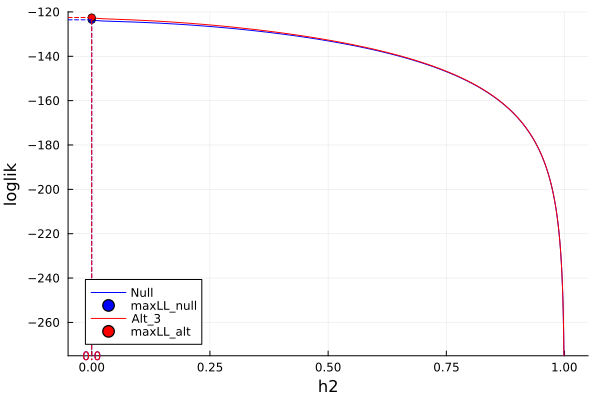

 26.482775 seconds (70.93 M allocations: 4.021 GiB, 4.82% gc time, 97.59% compilation time)


In [139]:
@time scan_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                              prior_variance = prior[1], prior_sample_size = prior[2],
                              plot_loglik = true, markerID = 3, h2_grid = collect(0.0:999).*0.001,
                              x_lims = [0.0, 1.0], y_lims = [-275, -120.0]);

In [140]:
BLAS.set_num_threads(Threads.nthreads())

In [141]:
BLAS.get_num_threads()

16

In [142]:
@time scan_results_ind_alt = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                  assumption = "alt", 
                                  prior_variance = prior[1], prior_sample_size = prior[2]);

 13.442810 seconds (11.82 M allocations: 14.368 GiB, 7.57% gc time, 0.21% compilation time)


In [143]:
@time scan_perms_results_ind = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                    prior_variance = prior[1], prior_sample_size = prior[2],
                                    permutation_test = true, nperms = 1000, original = true);

  0.957237 seconds (2.04 M allocations: 268.149 MiB, 4.68% gc time, 89.77% compilation time)


In [144]:
max_lods = vec(mapslices(x -> maximum(x), scan_perms_results_ind; dims = 1));

In [145]:
thrs = map(x -> quantile(max_lods, x), [0.85, 0.95]);

In [146]:
lp_id

29437

In [147]:
mean(scan_perms_results_ind[:, 1] .> 2.94)

0.0

In [148]:
thrs

2-element Vector{Float64}:
 2.896638126422173
 3.4268718725428533

In [149]:
single_results_ind = DataFrame(hcat(scan_results_ind.lod, scan_results_ind_alt.lod, scan_perms_results_ind[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [150]:
single_results_ind[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.44861,0.448609,0.44861
2,0.44861,0.448609,0.44861
3,0.44861,0.448609,0.44861
4,0.44861,0.448609,0.44861
5,0.44861,0.448609,0.44861
6,0.44861,0.448609,0.44861


#### For liver proteome means by strains

In [151]:
lp_strains_Y = Matrix{Float64}(BXD_pheno_strains_summary_df[:, 3:end]);
lp_strains_y = reshape(lp_strains_Y[:, lp_id], :, 1);

In [152]:
lpst_strains_Y = colStandardize(lp_strains_Y);
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [153]:
@time scan_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains; 
                                  prior_variance = prior[1], prior_sample_size = prior[2],
                                  optim_interval = 4);

  0.076321 seconds (206.24 k allocations: 40.237 MiB, 42.13% compilation time)


In [154]:
@time scan_results_strains_alt = scan(lpst_strains_y, geno_strains, kinship_strains;
                                      assumption = "alt",
                                      prior_variance = prior[1], prior_sample_size = prior[2]);

  1.631722 seconds (4.08 M allocations: 1.233 GiB, 12.98% gc time)


In [155]:
@time scan_perms_results_strains = scan(lpst_strains_y, geno_strains, kinship_strains;
                                        permutation_test = true, nperms = 1000, original = true, 
                                        prior_variance = prior[1], prior_sample_size = prior[2]);

  0.070793 seconds (214.75 k allocations: 85.974 MiB, 49.59% compilation time)


In [156]:
single_results_strains = DataFrame(hcat(scan_results_strains.lod, scan_results_strains_alt.lod, scan_perms_results_strains[:, 1]), ["scan_null", "scan_alt", "scan_perms.original"]);

In [157]:
single_results_strains[1:6, :]

Row,scan_null,scan_alt,scan_perms.original
,Float64,Float64,Float64
1,0.147528,0.359619,0.363103
2,0.147528,0.359619,0.363103
3,0.147528,0.359619,0.363103
4,0.147528,0.359619,0.363103
5,0.147528,0.359619,0.363103
6,0.147528,0.359619,0.363103


In [158]:
size(lp_strains_y)

(50, 1)

In [159]:
lpst_strains_y[1:5]./sqrt(0.5)

5-element Vector{Float64}:
  1.0226201850024244
 -0.007395742683977131
  0.8020068444624721
  1.234467432540759
 -0.5639098286938068

### Weighted Error Variances:

Assuming that

$$y = X_0 B_0+g\beta+\epsilon$$

where 

$$\epsilon \sim N(0,  \sigma^2_g K + \sigma^2_e V) $$ and 

the matrix $V$ is a diagonal but not necessarily an identity matrix.

Notice that since $V^{-1} = V^{-1/2}V^{-1/2}$, then the strategy is as such:

Let $$y^* = V^{-1/2}y = V^{-1/2}X0+V^{-1/2}g\beta+V^{-1/2}\epsilon$$

then 
$$V^{-1/2}\epsilon \sim N(0, \sigma^2_g V^{-1/2}KV^{-1/2}+\sigma^2_e V^{-1/2}VV^{-1/2} = \sigma^2_g K^*+\sigma^2_e I)$$

In [160]:
BXD_pheno_ind_summary_df[1:6, :]

Row,Sample,Strain,Strain_num,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,⋯
,String7,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,H1009,BXD9,9,11.349,11.534,17.587,17.517,17.309,16.574,16.323,16.263,16.24,16.052,15.355,15.795,15.4,15.03,14.831,14.914,14.755,14.389,14.272,13.992,14.291,13.762,13.167,12.662,10.913,14.723,14.348,13.345,14.228,13.862,13.902,13.687,11.613,10.245,14.409,15.147,12.34,14.404,13.775,14.293,14.461,14.23,14.065,14.258,14.31,13.616,13.541,13.46,13.293,12.937,12.717,15.149,14.36,14.833,14.341,14.579,14.316,14.049,13.817,13.656,13.297,13.78,12.843,12.439,11.074,14.065,13.915,13.994,13.907,13.247,13.356,12.815,14.702,13.637,16.398,16.402,16.271,16.0,15.909,15.647,15.021,13.726,7.236,3.295,13.794,14.838,14.908,14.664,13.055,12.612,13.323,18.252,16.889,17.118,16.443,15.683,14.183,⋯
2,H0370,BXD9,9,11.249,12.735,17.427,17.325,17.252,16.685,16.021,16.332,15.965,15.624,15.336,14.811,14.979,14.957,14.474,14.815,14.912,14.77,14.244,14.151,13.87,13.696,11.285,13.094,1

In [161]:
BXD_pheno_strains_summary_df[1:6, :]

Row,Strain,Number of Samples,P42209_DESGLNRK_2,P42209_GLRPLDVAFLR_3,Q99M02_VGDPVYR_2,Q99M02_VWIYPIK_2,Q99M02_LCDPSVK_2,Q99M02_CVLTTVDPDTGIIDR_2,Q99M02_LVQFDTSMK_2,Q99M02_QLQQVGTVSK_2,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_GRDCGDEVAQWFTNYLK_3,Q99M02_SIYQSSPLFGMYFSVEK_2,Q99M02_RQLQQVGTVSK_3,Q99M02_LYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4,Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_5,Q99M02_SIYQSSPLFGMYFSVEK_3,Q99M02_CVLTTVDPDTGIIDRK_3,Q99M02_CVLTTVDPDTGIIDR_3,Q99M02_TQAYRLVQFDTSMK_3,Q99M02_GVSVCETECTDMGLR_2,Q99M02_DCGDEVAQWFTNYLK_2,Q99M02_DRFWMVVK_2,Q99M02_GRDCGDEVAQWFTNYLK_2,Q99M02_DCGDEVAQWFTNYLK_3,Q99M02_EDGHMVTAR_2,Q99M02_RQLQQVGTVSK_2,P42208_TIISYIDEQFER_2,P42208_ILDEIEEHSIK_3,P42208_VNIVPVIAK_2,P42208_ASIPFSVVGSNQLIEAK_2,P42208_TVQIEASTVEIEER_2,P42208_LTVVDTPGYGDAINCR_2,P42208_ASIPFSVVGSNQLIEAK_3,P42208_STLINSLFLTDLYPER_3,Q9Z1S5_VNIIPVIAK_2,Q3KNM2_LGPVVYVLDLADR_2,Q9Z2Q6_LATPEDKQDIDKQYVGFATLPNQVHR_4,Q9Z2Q6_VNIVPILAK_2,Q9R1T4_RNEFLGELQK_3,Q9R1T4_STLMDTLFNTK_2,O55131_STLINSLFLTDLYSPEYPGPSHR_3,O55131_FEDYLNAESR_2,O55131_IYEFPETDDEEENKLVK_3,O55131_NLEGYVGFANLPNQVYR_2,O55131_DVTNNVHYENYR_3,O55131_ANWEAQQR_2,O55131_NLEGYVGFANLPNQVYR_3,O55131_ADTLTPEECQQFK_2,O55131_ILEQQNSSR_2,O55131_VQCCLYFIAPSGHGLKPLDIEFMK_4,O55131_TVQVEQSK_2,O55131_LKDSEAELQR_2,Q8CHH9_VNIIPLIAK_2,Q8CHH9_VNIIPIIAK_2,Q80UG5_ADTLTLEER_2,Q80UG5_STLINTLFK_2,Q80UG5_RTEITIVKPQESVLR_4,Q80UG5_DITSNIHFEAYR_3,Q80UG5_LEPRPSVAEVPYR_3,Q80UG5_FINDQYEK_2,Q80UG5_YLQEEVNINR_2,Q80UG5_VVNIVPVIAK_2,Q80UG5_SITHDIEEK_2,Q80UG5_IPEGSAVPATDAAPK_2,Q80UG5_SVQPTSEER_2,Q80UG5_QVESTASAAGPSR_2,Q8C1B7_FESDPATHNEPGVR_3,Q8C1B7_SYELQESNVR_2,Q8C1B7_NLSLSGHVGFDSLPDQLVNK_3,Q8C1B7_AAAQLLQSQAQQSGAQQTK_3,Q8C1B7_ELEEEVSNFQK_2,Q9ERR7_WNTDSVEEFLSEK_2,Q9ERR7_LLDDNGNIAEELSILK_2,Q9ERY9_YLEAEPVSR_2,P59708_ITAEEMYDIFGK_2,Q9DCS2_CLDSIAATTR_2,Q9DCS2_ISPQSNVDFDLTLR_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_4,Q9DCS2_QYVDPAQR_2,Q9DCS2_NKEPILSVLR_2,Q9DCS2_AQGLSNVK_2,Q9DCS2_VLEVASGSGQHAAHFAQAFPNAEWQPSDVDQR_5,Q9DCS2_MVDMPANNK_2,Q9DCS2_DTVLLEELGQASGLVLER_3,Q9DCS2_DTVLLEELGQASGLVLER_2,Q9JHJ3_LLHTADVCQLEVALVGASPR_3,A2A8E1_TIVEFECR_2,A2A8E1_ATLENVTNLRPVGEDFR_3,A2A8E1_ENSIDILSSTIK_2,A2A8E1_AQESVGIFEVTHQFVK_3,Q8BWR2_GLAYGLYLR_2,Q8VED9_IQTLSAIDTIK_2,Q9CRB3_LFFDTER_2,Q9CRB3_FHVPLLLSPWSYTTYR_3,Q9CRB3_TSYTNLDGR_2,Q9CRB3_LEAPCQQWMELR_2,Q9CRB3_CPGLLTPSQIKPGTYK_3,Q9CRB3_LEAPCQQWMELR_3,Q9CRB3_CPGLLTPSQIKPGTYK_2,⋯
,String7,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,BXD9,4,11.5968,11.3575,17.6545,17.4327,17.384,16.6528,16.2222,16.3227,16.1728,15.9748,15.389,15.5355,15.2248,15.0568,14.8253,14.9138,14.701,14.4827,14.435,14.1852,14.181,13.767,12.6575,13.0293,12.1615,14.4335,14.329,13.121,13.7155,13.792,13.6792,13.588,10.4722,10.8012,14.4032,15.1105,12.296,13.9857,13.5813,14.4152,14.314,14.0682,14.0802,14.0095,14.2483,13.491,13.2422,13.0218,13.1207,12.596,12.545,15.0785,14.098,14.998,14.2985,14.5045,14.4415,14.059,13.7245,13.7157,13.0465,13.9132,12.589,12.211,11.2688,13.8725,13.8287,13.6202,13.7073,13.2155,13.211,12.4328,14.7125,13.2955,16.292,16.3242,16.059,15.9615,15.9207,15.8298,14.756,13.4055,10.155,10.0538,13.8277,15.0023,14.9838,14.7153,13.053,13.0248,13.3317,18.24,17.0547,17.0873,16.1775,15.6133,14.0457,13.528,⋯
2,BXD13,1,11.687,11.524,17.362,17.367,17.071,16.465,15.97,15.98,16.108,1

In [162]:
# weights_true = float.(1.0 ./BXD_pheno_strains_summary_df[:, 2]);
weights_true = sqrt.(BXD_pheno_strains_summary_df[:, 2]);

In [163]:
@time lod_from_pkg = scan(lpst_strains_y, geno_strains, kinship_strains;
                          weights = weights_true,
                          prior_variance = prior[1], prior_sample_size = prior[2]);

  0.326830 seconds (624.44 k allocations: 66.187 MiB, 15.90% gc time, 85.64% compilation time)


In [164]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756

In [165]:
lod_from_pkg.lod[1:10]

10-element Vector{Float64}:
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756
 0.44542169852154756

In [166]:
lpst_strains_y_test = rowMultiply(lpst_strains_y, weights_true);
geno_strains_test = rowMultiply(geno_strains, weights_true);
covar_strains_test = rowMultiply(ones(50, 1), weights_true);
# kinship_strains_test = rowMultiply(kinship_strains, weights_true);

In [167]:
test_W = rowMultiply(kinship_strains, weights_true);

In [168]:
test_K = rowMultiply(permutedims(test_W), weights_true);

In [169]:
lod_by_hand = scan(lpst_strains_y_test, geno_strains_test, covar_strains_test, test_K;
                   addIntercept = false, 
                   prior_variance = prior[1], prior_sample_size = prior[2]);

In [170]:
sum(abs.(lod_by_hand.lod .- lod_from_pkg.lod))

9.867273226049633e-6

In [171]:
lp_id

29437

In [172]:
lp_names[lp_id]

"Q9Z2I8_SSGLPITSAVDLEDAAK_3"

### Test:

In [173]:
lp_id = 29437

29437

In [255]:
lp_id = 241

241

In [256]:
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1);

In [257]:
lpst_ind_y = reshape(lpst_ind_Y[:, lp_id], :, 1);

In [258]:
prior = [1.0, 0.0]

2-element Vector{Float64}:
 1.0
 0.0

In [259]:
grid_list = collect(0:999).*0.001;

Loglik plot: 


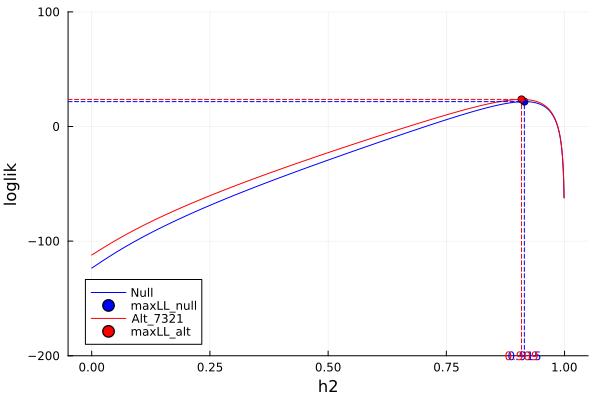

(sigma2_e = 0.16880624413711928, h2_null = 0.915299056559069, lod = [0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974, 0.1678774075707974  …  0.0921515465737377, 0.12135688586455995, 0.3144526747612826, 0.3144526747612826, 0.6621491338575574, 0.6061397322915791, 0.6621491338575574, 0.6061397322915791, 0.8010423995218856, 0.8010423995218856])

In [281]:
test_a = scan(lpst_ind_y, geno_ind, kinship_ind_from_strains;
              # weights = weights_true,
              prior_variance = 1.0, prior_sample_size = 0.0, 
              optim_interval = 10, plot_loglik = true, markerID = 7321, h2_grid = grid_list, y_lims = [-200.0, 100.0])

Loglik plot: 


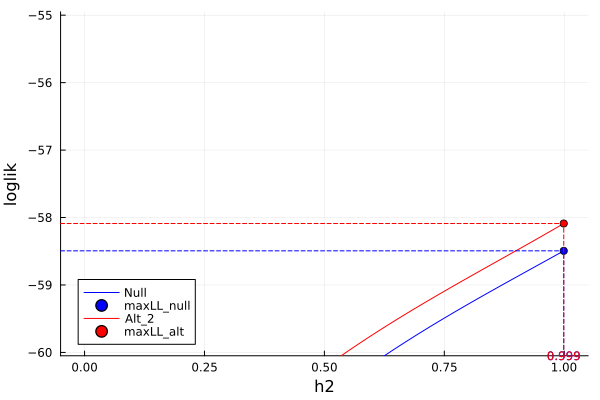

(sigma2_e = 4.1049377249986253e-8, h2_null = 0.9999999816824213, lod = [0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947, 0.17615920414006947  …  0.09076635500657737, 0.12317486576078895, 0.3136544602489355, 0.3136544602489355, 0.6722781742264816, 0.6116341980753282, 0.6722781742264816, 0.6116341980753282, 0.8241712798392475, 0.8241712798392475])

In [288]:
test_a = scan(lpst_strains_y, geno_strains, kinship_strains;
              weights = weights_true,
              prior_variance = 1.0, prior_sample_size = 0.0, 
              optim_interval = 10, plot_loglik = true, markerID = 2, h2_grid = grid_list, y_lims = [-60.0, -55.0])

In [262]:
test_a.h2_null

0.9999999816824213

In [263]:
@time test_A = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                  weights = weights_true, 
                                  prior_variance = 1.0, prior_sample_size = 0.1);

 55.668381 seconds (455.97 M allocations: 90.124 GiB, 5.82% gc time)


In [266]:
test_A.h2_null_list[lp_id]

0.931

In [269]:
test_A_exact.h2_null_list[lp_id]

0.9311279236201185

In [267]:
findall(test_A.h2_null_list .>= 0.5)

1954-element Vector{Int64}:
    37
    39
    42
    53
    58
    61
    67
    78
   123
   191
   215
   231
   232
     ⋮
 32220
 32222
 32223
 32227
 32228
 32231
 32270
 32372
 32420
 32426
 32429
 32437

In [183]:
maximum(abs.(test_a.lod .- lod_by_hand.lod))

2.6928413624628664

In [184]:
scan_results_strains.h2_null

3.629255560717888e-16

In [185]:
@time test_A_exact = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                   weights = weights_true, 
                                   prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

190.379060 seconds (2.81 G allocations: 486.444 GiB, 23.83% gc time, 0.16% compilation time)


In [186]:
test_A_exact.h2_null_list[lp_id]

0.47700360368597094

In [246]:
findall(test_A_exact.h2_null_list .>= 0.9)

117-element Vector{Int64}:
   123
   241
   495
   500
   501
   897
   955
   959
  1515
  2750
  3199
  3200
  3210
     ⋮
 31327
 31328
 31329
 31330
 31331
 31333
 31334
 31338
 31341
 32158
 32213
 32426

In [187]:
test_A.h2_null_list[lp_id]

0.48

In [188]:
hcat(test_A_exact.L[:, lp_id], test_a.lod, test_A.L[:, lp_id])

7321×3 Matrix{Float64}:
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.346766    0.470132   0.347721
 0.226185    0.289321   0.225985
 ⋮                      
 0.00849478  0.0190723  0.00827439
 0.00849478  0.0190723  0.00827439
 0.00849478  0.0190723  0.00827439
 0.147244    0.366897   0.148533
 0.49964     0.751512   0.501627
 0.49964     0.751512   0.501627
 0.469364    0.743515   0.47156
 0.256173    0.401996   0.257254
 0.469364    0.743515   0.47156
 0.256173    0.401996   0.257254
 0.284542    0.461123   0.285633
 0.284542    0.461123   0.285633

In [189]:
sum(abs.(test_A_exact.L[:, lp_id] .- test_a.lod))

612.4693881351816

In [190]:
maximum(abs.(test_A.L[:, lp_id] .- test_a.lod))

0.725066072163604

### Multiple-trait genome scans:

In [ ]:
BLAS.set_num_threads(Threads.nthreads())

In [ ]:
BLAS.get_num_threads()

In [ ]:
grid_list = collect(0.0:0.01:0.99);

#### For individual liver proteome

In [ ]:
size(lpst_ind_Y)

In [ ]:
size(lpst_strains_Y)

In [ ]:
Threads.nthreads()

In [ ]:
@time bulkscan_results_ind_null = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
BLAS.set_num_threads(Threads.nthreads())

In [ ]:
@time bulkscan_results_ind_alt_grid = bulkscan_alt_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

In [ ]:
@time bulkscan_results_ind_null_grid = bulkscan_null_grid(lpst_ind_Y, geno_ind, kinship_ind_from_strains, grid_list);

#### For liver proteome means by strains

In [ ]:
@time bulkscan_results_strains_null = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                    prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
BLAS.set_num_threads(Threads.nthreads())

In [ ]:
@time bulkscan_results_strains_alt_grid = bulkscan_alt_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list);

In [ ]:
@time bulkscan_results_strains_null_grid = bulkscan_null_grid(lpst_strains_Y, geno_strains, kinship_strains, grid_list;
                                                              prior_variance = 1.0, prior_sample_size = 0.1);

In [ ]:
pwd()

In [ ]:
bulkscan_results_strains_null_grid.L

### Write-in results:

In [ ]:
lp_names[lp_id]

In [ ]:
output_folder_ind_nh = "BulkLMM_Outputs/Ind_NoHub";
output_folder_strains_nh = "BulkLMM_Outputs/Strains_NoHub";

In [ ]:
pwd()

#### Single_trait:

#### Multiple_traits:

In [ ]:
b_ind_null = vcat(bulkscan_results_ind_null.h2_null_list', bulkscan_results_ind_null.L);

In [ ]:
b_ind_null_grid = vcat(bulkscan_results_ind_null_grid.h2_null_list', bulkscan_results_ind_null_grid.L);

In [ ]:
b_strains_null = vcat(bulkscan_results_strains_null.h2_null_list', bulkscan_results_strains_null.L);

In [ ]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

In [ ]:
b_strains_null_grid = vcat(bulkscan_results_strains_null_grid.h2_null_list', bulkscan_results_strains_null_grid.L);

## Examine loglikelihood:

In [ ]:
findall(map(x -> (x <= 0.97) & (x >= 0.93), bulkscan_results_strains_null_grid.h2_null_list))

In [ ]:
lp_id = 31663;

In [ ]:
lp_id = 29437;

In [ ]:
bulkscan_results_strains_null_grid.h2_null_list[lp_id]

In [ ]:
lpst_strains_y = reshape(lpst_strains_Y[:, lp_id], :, 1)

In [ ]:
## Inputs: Original data, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    Gj = reshape(G[:, markerID], :, 1);
    (y0, X0, lambda0) = transform_rotation(y, Gj, K; addIntercept = true);
    w = makeweights(h2, lambda0);
    X0_inter = reshape(X0[:, 1], :, 1);
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X0, w, prior).ell)
end

function getLL(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1}, 
               markerID::Int64, h2::Float64; prior::Array{Float64, 1} = [0.0, 0.0])
    
    n = size(y0, 1);
    w = makeweights(h2, lambda0);

    X0_inter = reshape(X0[:, 1], :, 1);
    X_design = zeros(n, 2);
    X_design[:, 1] = X0[:, 1];
    X_design[:, 2] = X0[:, markerID+1];
    
    return (ll_null = wls(y0, X0_inter, w, prior).ell, ll_markerID = wls(y0, X_design, w, prior).ell)
end

In [ ]:
@time opt = optimize(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0)

In [ ]:
@time gridopt = gridbrent(x -> -getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior).ll_null, 0.0, 1.0, 10);

In [ ]:
gridopt.minimizer

In [ ]:
@time ml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                     prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time reml_null = scan(lpst_strains_y, geno_strains, kinship_strains; 
                       reml = true, 
                       prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time ml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                    reml = false, assumption = "alt", 
                    prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
@time reml_alt = scan(lpst_strains_y, geno_strains, kinship_strains; 
                      reml = true, assumption = "alt",
                      prior_variance = prior[1], prior_sample_size = prior[2]);

In [ ]:
opt.minimizer

In [ ]:
opt.minimum

In [ ]:
gridopt

In [ ]:
prior

In [ ]:
prior = [1.0, 0.1];

In [ ]:
@time begin
    ind_ll = map(x -> getLL(lpst_ind_y, geno_ind, kinship_ind_from_strains, 1997, x; prior = prior), h2_grid);
    strains_ll = map(x -> getLL(lpst_strains_y, geno_strains, kinship_strains, 1997, x; prior = prior), h2_grid);

    ind_ell_list2 = zeros(1000);
    ind_ell_list_alt2 = zeros(1000);
    strains_ell_list = zeros(1000);
    strains_ell_list_alt = zeros(1000);
    for k in 1:1000 
        ind_ell_list2[k] = ind_ll[k].ll_null;
        strains_ell_list[k] = strains_ll[k].ll_null;
        strains_ell_list_alt[k] = strains_ll[k].ll_markerID;
    end
end

In [ ]:
h2_grid = 0.001*collect(0:999);

In [ ]:
@time begin
    ind_ell_list = zeros(1000);
    ind_ell_list_alt = zeros(1000);


    (lpst_ind_y0, geno_ind0, lambda_ind0) = transform_rotation(lpst_ind_y, geno_ind, kinship_ind_from_strains;
                                                              addIntercept = true);
    markerID = 1997;

    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(lpst_ind_y0, geno_ind0, lambda_ind0, markerID, curr_h2; prior = prior);
        ind_ell_list[k] = output.ll_null;
        ind_ell_list_alt[k] = output.ll_markerID;
    end
    
end

In [ ]:
sum(ind_ell_list .- ind_ell_list2)

In [ ]:
ind_ell_list .- ind_ell_list_alt

In [ ]:
gridopt.minimizer

In [ ]:
plot(collect(0.001:0.001:0.999), strains_ell_list, label = "Intercept", ylab = "loglik", xlab = "h2")
# plot!(collect(0.001:0.001:0.999), strains_ell_list_alt, label = "alt")
scatter!([opt.minimizer], [-opt.minimum], label = "brents_optim", color = "blue")
plot!([opt.minimizer, opt.minimizer], [-35.5, -opt.minimum], color = "blue", style = :dash, label = "")
plot!([-0.02, opt.minimizer], ones(2).* (-opt.minimum), color = "blue", style = :dash, label = "")
# scatter!([gridopt.minimizer], [-gridopt.minimum], label = "grid_brents_optim", color = "red")
# plot!([gridopt.minimizer, gridopt.minimizer], [-35.5, -gridopt.minimum], color = "red", style = :dash, label = "")
# plot!([-0.02, gridopt.minimizer], ones(2).* (-gridopt.minimum), color = "red", style = :dash, label = "")
annotate!(opt.minimizer, -35.5, 
          text("0.9275", :blue, :below, 8))
xlims!((-0.025, 1.05))
ylims!((-35.0, -24.0))

In [ ]:
min(1.0, 0.1)

In [ ]:
min([1.0, 1.2, 3.0, 2.3])

In [ ]:
typeof(1.0:10.0)

In [ ]:
?ylims

In [ ]:
findmax(strains_ell_list)

In [ ]:
plot(collect(1:999).*0.001, ind_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP individuals", color = "blue", legend=:bottomleft)
plot!(collect(1:999).*0.001, strains_ell_list, xlabel = "h2", ylabel = "loglik", label = "LP strain means", color = "red")

## Examine hsqs, maxLods:

In [ ]:
L_ind_null = bulkscan_results_ind_null.L;

In [ ]:
L_ind_null_grid = bulkscan_results_ind_null_grid.L;

In [ ]:
function getMaxLODs(L::Array{Float64, 2})
    
    m = size(L, 2);
    max_marker = Array{Int64, 1}(undef, m);
    max_lod = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        result_i = findmax(L[:, i]); 
        max_marker[i] = result_i[2];
        max_lod[i] = result_i[1];
    end
    
    return (max_markers = max_marker, max_lod = max_lod);
end

In [ ]:
@time begin
    max_results_ind = getMaxLODs(L_ind_null);
    max_results_ind_grid = getMaxLODs(L_ind_null_grid);
end;

In [ ]:
pwd()

In [ ]:
# CSV.write("output/max_results_ind.csv", DataFrame(round.(hcat(max_results_ind.max_markers, max_results_ind.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [ ]:
# CSV.write("output/max_results_ind_grid.csv", DataFrame(round.(hcat(max_results_ind_grid.max_markers, max_results_ind_grid.max_lod), digits = 2), ["max_marker", "max_lod"]))

In [ ]:
@time bulkscan_results_ind_null_4 = bulkscan_null(lpst_ind_Y, geno_ind, kinship_ind_from_strains; nb = Threads.nthreads(),
                                                  prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
@time bulkscan_results_null_strains_4 = bulkscan_null(lpst_strains_Y, geno_strains, kinship_strains; nb = Threads.nthreads(),
                                                      prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
L_ind = bulkscan_results_ind_null.L;
L_strains = bulkscan_results_strains_null.L;
h2s_ind = bulkscan_results_ind_null.h2_null_list;
h2s_strains = bulkscan_results_strains_null.h2_null_list;

In [ ]:
L_ind_4 = bulkscan_results_ind_null_4.L;
L_strains_4 = bulkscan_results_null_strains_4.L;
h2s_ind_4 = bulkscan_results_ind_null_4.h2_null_list;
h2s_strains_4 = bulkscan_results_null_strains_4.h2_null_list;

## Get Plot:

In [ ]:
BXD_pmap = CSV.read("data/BXD_pmap.csv", DataFrame);
BXD_gmap = CSV.read("data/BXD_gmap.csv", DataFrame);

In [ ]:
max_results_df_ind = CSV.read("output/max_results_ind.csv", DataFrame);

In [ ]:
max_results_df_ind_grid = CSV.read("output/max_results_ind_grid.csv", DataFrame);

In [ ]:
using RecipesBase, Plots, Plots.PlotMeasures, ColorSchemes

In [ ]:
function plot_eQTL2(lodc::Array{Float64, 2}, gmap::DataFrame, phenocovar::DataFrame;
                thr::Float64 = 5.0, kwargs...)
    
    x, y, z, mysteps, mychr = get_eQTL_accMb(
                                lodc, 
                                phenocovar,
                                gmap;
                                thr = thr,
                                kwargs...
                              )

    eQTLplot(x, y, z, mysteps, mychr, kwargs...)

end

In [ ]:
BXD_pmap.Chr = convert.(String, BXD_pmap.Chr);

In [ ]:
BXD_gmap.Chr = convert.(String, BXD_gmap.Chr);

In [ ]:
plot_eQTL2(Matrix(max_results_df_ind), BXD_gmap, BXD_pmap)

In [ ]:
lp_id

In [ ]:
lp_ind_y

In [ ]:
lpst_ind_y

In [ ]:
scan_results_ind_alt.lod

### Heritabilities:

In [ ]:
findall(abs.(h2s_strains .- h2s_strains_4) .>= 0.5)

In [ ]:
findmax(abs.(h2s_strains .- h2s_strains_4))

In [ ]:
largest_h2diff_strains_y = reshape(lpst_strains_Y[:, 6], :, 1);

In [ ]:
@time test_scan_results_opt1 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 1);

In [ ]:
@time test_scan_results_opt2 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 2);

In [ ]:
@time test_scan_results_opt4 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 4);

In [ ]:
@time test_scan_results_opt10 = scan(largest_h2diff_strains_y, geno_strains, kinship_strains; 
                             prior_variance = 1.0, prior_sample_size = 0.1, optim_interval = 10);

In [ ]:
test_scan_results_opt1.h2_null

In [ ]:
test_scan_results_opt2.h2_null

In [ ]:
test_scan_results_opt4.h2_null

In [ ]:
test_scan_results_opt10.h2_null

In [ ]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.0)

In [ ]:
getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, 0.66)

In [ ]:
# ind_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x), collect(0.0:0.001:0.999));
l_strains_ll = map(x -> getLL(largest_h2diff_strains_y, geno_strains, kinship_strains, 1, x;
                              prior = [1.0, 0.1]), 
                   collect(0.0:0.001:0.999));

# ind_ell_list = zeros(999);
l_strains_ell_list = zeros(999);
l_strains_ell_list_alt = zeros(999);
for k in 1:999 
    # ind_ell_list[k] = ind_ll[k].ll_null;
    l_strains_ell_list[k] = l_strains_ll[k].ll_null;
    l_strains_ell_list_alt[k] = l_strains_ll[k].ll_markerID;
end

In [ ]:
plot(l_strains_ell_list)

In [ ]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

In [ ]:
plot(exp.(l_strains_ell_list .- maximum(l_strains_ell_list)))

### Maximum lod scores:

In [ ]:
histogram(max_results_ind.max_lod, label = "Maximum lod - Individual LP")

In [ ]:
histogram(max_results_strains.max_lod, label = "Maximum lod - Strain mean LP")

In [ ]:
plot(max_results_ind.max_lod .- max_results_strains.max_lod, label = "Max lod: ind - strains")
hline!(x -> x = 0.0, label = "")

In [ ]:
mean(max_results_ind.max_lod .- max_results_strains.max_lod .>= 0.0)

In [ ]:
pwd()

## Run GEMMA for single-trait scans:

In [ ]:
pwd()

In [ ]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [ ]:
run(`$gemma -h`)

In [ ]:
function transform_bxd_pheno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, iter::Int64)
    pheno = CSV.read(inputfile, DataFrame);
    pheno = Matrix{Float64}(pheno[:, 3:end]);
    open(outputfile, "w") do io
        writedlm(io, pheno[:, iter])
    end
    return pheno
end

In [ ]:
function transform_bxd_geno_to_gemma2(inputfile::AbstractString, outputfile::AbstractString, 
                                      startCol::Int64)
    data = CSV.read(inputfile, DataFrame);
    
    marker_names = names(data)[startCol:end];
    data = 2 .* data[:, startCol:end] |> x -> Matrix{Float64}(x)
    # data = data[:, startCol:end] |> x -> Matrix{Float64}(x)
    minor_allele = fill("A", length(marker_names), 1);
    major_allele = fill("B", length(marker_names), 1);
    output = hcat(hcat(marker_names, minor_allele, major_allele), transpose(data))
    writeToFile(output, outputfile)
    return output
end

In [ ]:
lp_id

In [ ]:
# transform_bxd_geno_to_gemma2("data/GN886_geno_strains_summary.csv", "data/GEMMA_data/GN886_geno_strains_summary.txt", 2);
# transform_bxd_geno_to_gemma2("data/GN886_geno_summary.csv", "data/GEMMA_data/GN886_geno_ind_summary.txt", 4);

In [ ]:
lp_id = 29437;

In [ ]:
transform_bxd_pheno_to_gemma2("data/GN886_pheno_strain_means_summary.csv", "data/GEMMA_data/GN886_pheno_strains_summary.txt", lp_id);
transform_bxd_pheno_to_gemma2("data/GN886_pheno_summary.csv", "data/GEMMA_data/GN886_pheno_ind_summary.txt", lp_id);

In [ ]:
# writedlm("data/GEMMA_data/kinship_strains.txt", kinship_strains, '\t')
# writedlm("data/GEMMA_data/kinship_ind.txt", kinship_ind_from_strains, '\t')

In [ ]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

In [ ]:
function gemmaWrapper(pheno_filename::String, geno_filename::String,
                      kinship_filename::String, output_filename::String)
    
    run(`$gemma -g $geno_filename -p $pheno_filename -k $kinship_filename -lmm 2 -lmax 1000000 -o $output_filename`)
    
end

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_strains_summary.txt", 
                   "data/GEMMA_data/GN886_geno_strains_summary.txt",
                   "data/GEMMA_data/kinship_strains.txt",
                   "results_strains.txt");

In [ ]:
@time gemmaWrapper("data/GEMMA_data/GN886_pheno_ind_summary.txt", 
                   "data/GEMMA_data/GN886_geno_ind_summary.txt",
                   "data/GEMMA_data/kinship_ind.txt",
                   "results_ind.txt");

In [ ]:
sum(eigen(kinship_ind_from_strains).values.<0.0001)

In [ ]:
gemma_results_strains = readdlm("output/results_strains.txt.assoc.txt", '\t');
gemma_results_ind = readdlm("output/results_ind.txt.assoc.txt", '\t');

In [ ]:
gemma_strains = gemma_results_strains[2:end, 10] |> x -> Array{Float64}(x);
gemma_ind = gemma_results_ind[2:end, 10] |> x -> Array{Float64}(x);

In [ ]:
gemma_strains_lod = p2lod.(gemma_strains, 1);
gemma_ind_lod = p2lod.(gemma_ind, 1);

In [ ]:
hcat(gemma_ind_lod, scan_results_ind.lod, bulkscan_results_null_grid_ind.L[:, lp_id])

In [ ]:
hcat(gemma_strains_lod, scan_results_strains.lod, bulkscan_results_null_strains.L[:, lp_id])

In [ ]:
lookRange = 1:7321

In [ ]:
plot(gemma_strains_lod[lookRange], label = "GEMMA_strains");
# plot!(scan_results_strains_alt_hub.lod[lookRange], label = "BulkLMM_strains")
plot!(bulkscan_results_null_strains.L[lookRange, lp_id], label = "BulkLMM_strains")

In [ ]:
scan_results_ind.h2_null